In [1]:
import sys, os
sys.path.append(os.environ['rapp'])
sys.path.append(os.environ['raco'])
sys.path.append(os.environ['rapl'] + '/azav')

import numpy as np
import scipy as sp
import pickle

import matplotlib.pyplot as plt

%matplotlib notebook

from azav_util import *
from plotcommon import *
from common import *

In [2]:
# Get Rachel's solar data
di = get_dict('gongdata/avgong1995-2009rls.pkl')
di.keys()

dict_keys(['om', 'om_err', 'nt', 'nr', 'tt', 'rr', 'sint', 'cost', 'rr_2d', 'tt_2d', 'sint_2d', 'cost_2d', 'xx', 'zz'])

In [3]:
# read in model S
fname = os.environ['notes'] + '/Model_S/Model_S.pkl'
model_S = get_dict(fname)
model_S.keys()

dict_keys(['msun', 'rsun', 'lsun', 'zsun', 'x0sun', 'alphasun', 'agesun', 'rr', 'lnq', 'grav', 'tmp', 'prs', 'rho', 'xfrac', 'lum', 'opa', 'eps', 'gamma', 'gamma_ad', 'delta', 'c_p', 'mue', 'ne', 'dsdr', 'nsq', 'zfrac', 'nu', 'kappa', 'eta', 'prm', 'pr', 'drhodr', 'dtmpdr', 'dprsdr', 'dlnrho', 'dlntmp', 'dlnprs', 'gas_constant', 'ircut', 'rcut', 'irbcz', 'rbcz', 'frad', 'heat', 'rtach', 'dtach', 'irtach', 'irtach1', 'irtach2', 'rtach1', 'rtach2'])

In [4]:
# cut the data off below 0.5*rsun (like in Rachel's plot)
rbot = 0.5*model_S['rsun']

In [5]:
print("common:  ", rsun)
print("model S: ", model_S['rsun'])
print("GONG   : ", np.max(di['rr']))

common:   69570000000.0
model S:  69599062580.0
GONG   :  1.00071


In [6]:
# they're a bit different... use model_S rsun for consistency
rsun = model_S['rsun']

In [7]:
# diffrot in "lab" frame
Om_nhz = di['om']
Om_err_nhz = di['om_err']

Om = Om_nhz*1e-9*(2*np.pi) # nHz --> rad/s

nt = di['nt']
nr = di['nr']

tt = di['tt']
tt_lat = 180./np.pi*(np.pi/2-tt)
rr = di['rr']*rsun

cost = di['cost']
sint = di['sint']

cost_2d = di['cost_2d']
sint_2d = di['sint_2d']

rr_2d = di['rr_2d']*rsun

xx = di['xx']
zz = di['zz']

In [8]:
# get rotation rate derivatives
dOmdr = np.gradient(Om, rr, axis=1)
dOmdt = np.gradient(Om, tt, axis=0)/rr_2d
dOmdz = cost_2d*dOmdr - sint_2d*dOmdt
dOmdl = sint_2d*dOmdr + cost_2d*dOmdt

In [9]:
# interpolate model S onto radial grid

In [10]:
rr_model_S = model_S['rr']

y = model_S['grav']
f = sp.interpolate.interp1d(rr_model_S, y)
grav = f(rr)

y = model_S['c_p']
f = sp.interpolate.interp1d(rr_model_S, y)
c_p = f(rr)

y = model_S['tmp']
f = sp.interpolate.interp1d(rr_model_S, y)
tmp = f(rr)

y = model_S['rho']
f = sp.interpolate.interp1d(rr_model_S, y)
rho = f(rr)

y = model_S['prs']
f = sp.interpolate.interp1d(rr_model_S, y)
prs = f(rr)

y = model_S['delta'] # -dlnrho/dlntmp
f = sp.interpolate.interp1d(rr_model_S, y)
delta = f(rr)

y = model_S['dlntmp']/model_S['dlnprs'] # -dlnrho/dlntmp
f = sp.interpolate.interp1d(rr_model_S, y)
dtdp = f(rr)

y = model_S['dsdr']/model_S['dlnprs'] # -dlnrho/dlntmp
f = sp.interpolate.interp1d(rr_model_S, y)
dsdp = f(rr)/c_p

In [46]:
len(model_S['tmp'])

2482

In [11]:
# integration and "priming" functions
def integrate_from_equator(arr):
    int_arr = np.zeros((nt, nr))
    for it in range(nt):
        int_arr[it, :] = np.trapz(arr[:it+1, :], tt[:it+1], axis=0)
    return int_arr

def zero_out(arr):
    arr_sph = np.sum(arr*sint_2d, axis=0)/np.sum(sint)
    return arr - arr_sph.reshape((1, nr))

def volav_in_radius_loc(arr, r1, r2):
    ir1, ir2 = inds_from_vals(rr, [r2, r1])
    arr_mean = np.trapz((arr*rr_2d**2)[:, ir1:ir2+1], rr[ir1:ir2+1], axis=1)
    arr_mean /= np.trapz((rr**2)[ir1:ir2+1], rr[ir1:ir2+1])
    return arr_mean

In [12]:
# compute thermal anomalies, dim and nondim

# from thermal wind
rhs_tw = (1./(grav*delta)).reshape((1, nr)) * rr_2d**2*sint_2d * (2*Om*dOmdz)
s_dev_nd_tw = zero_out(integrate_from_equator(rhs_tw))
t_dev_nd_tw = np.copy(s_dev_nd_tw)
s_dev_tw = s_dev_nd_tw*c_p.reshape((1, nr))
t_dev_tw = t_dev_nd_tw*tmp.reshape((1, nr))

# from centrifugal force
rhs_cent = (rho/prs).reshape((1, nr)) * rr_2d**2*sint_2d * cost_2d * Om**2
p_dev_nd_cent = zero_out(integrate_from_equator(rhs_cent))
s_dev_nd_cent = dsdp.reshape((1, nr)) * p_dev_nd_cent
t_dev_nd_cent = dtdp.reshape((1, nr)) * p_dev_nd_cent
s_dev_cent = s_dev_nd_cent*c_p.reshape((1, nr))
t_dev_cent = t_dev_nd_cent*tmp.reshape((1, nr))

# from quadrupole
J2 = 2.2e-7
gtheta = g_univ*msun*rsun**2/rr_2d**4 * 1.5 * J2 * sint_2d*cost_2d
rhs = (rho/prs).reshape((1, nr)) * rr_2d * gtheta
p_dev_nd_quad = zero_out(integrate_from_equator(rhs))
s_dev_nd_quad = dsdp.reshape((1, nr)) * p_dev_nd_quad
t_dev_nd_quad = dtdp.reshape((1, nr)) * p_dev_nd_quad
s_dev_quad = s_dev_nd_quad*c_p.reshape((1, nr))
t_dev_quad = t_dev_nd_quad*tmp.reshape((1, nr))

In [13]:
# calculate contrasts
dt_cent = (t_dev_cent[-1, :] - t_dev_cent[0, :])/tmp
dt_quad = (t_dev_quad[-1, :] - t_dev_quad[0, :])/tmp
dt_tw = (t_dev_tw[-1, :] - t_dev_tw[0, :])/tmp

In [14]:
# Okay make a decent paper plot, showing all the different temperatures. 
# figure dimensions from scratch
ncol = 3
width_inches = 7 + 1/16
margin_inches = 1/8 # margin width in inches (for both x and y) and 
    # horizontally in between figures
margin_left_inches = 1/2  # label Meridional circulation
margin_right_inches = 1/4
sub_margin_bottom_inches = 1/2
    # larger bottom margin to make room for colorbar
sub_margin_top_inches = 1/4 # wider top title
margin_top_inches = 0 # for overall title
lineplot_width_inches = 1.
lineplot_margin_left_inches = 1/4
lineplot_margin_bottom_inches = 3/8

sub_width_inches = (width_inches - (lineplot_width_inches + lineplot_margin_left_inches + margin_inches) -\
                    (ncol-1)*margin_inches - margin_right_inches - margin_left_inches)/ncol 
sub_height_inches = 1*sub_width_inches

height_inches = 1*(sub_height_inches + sub_margin_bottom_inches + sub_margin_top_inches) + sub_margin_top_inches

lineplot_height_inches = height_inches - sub_margin_top_inches - lineplot_margin_bottom_inches

# things in "figure units"
margin_x = margin_inches/width_inches
margin_y = margin_inches/height_inches
margin_right = margin_right_inches/width_inches
margin_left = margin_left_inches/width_inches

margin_top = margin_top_inches/height_inches
sub_margin_top = sub_margin_top_inches/height_inches
sub_margin_bottom = sub_margin_bottom_inches/height_inches
sub_width = sub_width_inches/width_inches
sub_height = sub_height_inches/height_inches  
lineplot_margin_left = lineplot_margin_left_inches/width_inches
lineplot_margin_bottom = lineplot_margin_bottom_inches/height_inches
lineplot_height = lineplot_height_inches/height_inches
lineplot_width = lineplot_width_inches/width_inches
print ("fig size: ", width_inches, height_inches)
print ("az size: ", sub_width_inches, sub_height_inches)
print ("lineplot size: ", lineplot_width_inches, lineplot_height_inches)

fig size:  7.0625 2.5625
az size:  1.5625 1.5625
lineplot size:  1.0 1.9375


In [15]:
# common parameters
fontsize = 7
#fontsize_big = 9
#linecolors = ['m', 'g', 'k']
#linestyles = ['-.', ':', '--']
linecolors = 'k'
linestyles = '--'
#contourstyles = 3*['-'] + ['--'] + 3*['-']
ncontours = 7
cbar_aspect = 1/20
cbar_prec = 1
rvals = np.array([0.695, 0.745, 0.95])*rsun

# print the actual values we come up with for rvals
irvals = inds_from_vals(rr, rvals)
print("rvals actual =", rr[irvals]/rsun)

rvals actual = [0.691917 0.749417 0.947243]


<IPython.core.display.Javascript object>


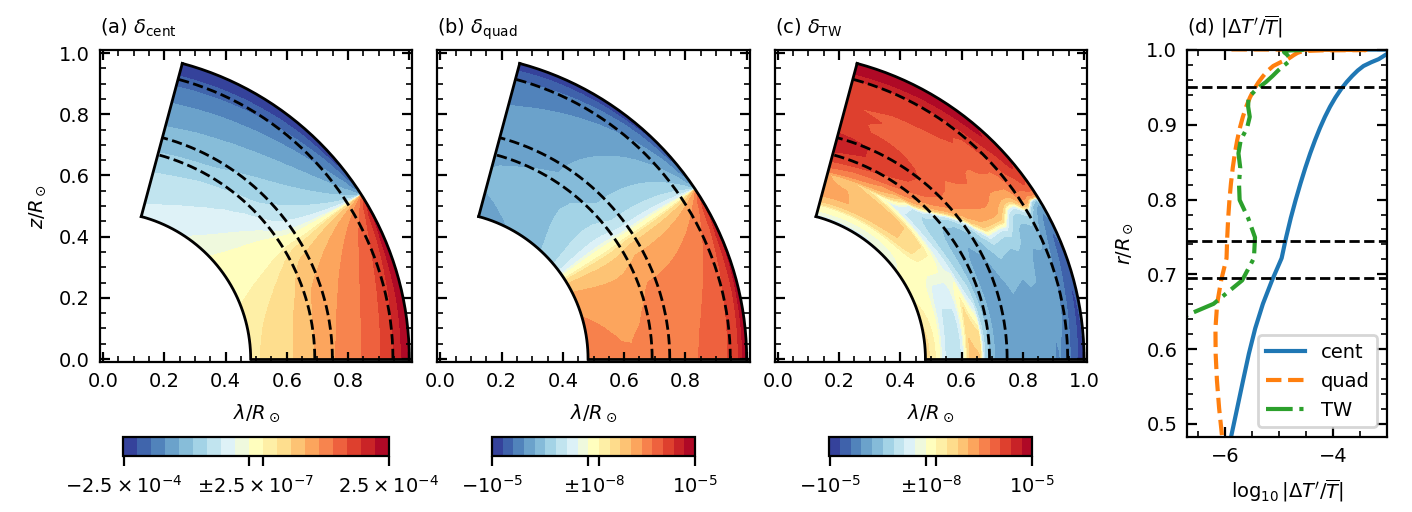

In [16]:
# Generate the actual figure of the correct dimensions
plt.close()
fig = plt.figure(figsize=(width_inches, height_inches))
axs = []


maxabses = [2.5e-4, 1e-5, 1e-5]
linthreshes = [2.5e-7, 1e-8, 1e-8]

# make subplots
profiles = [t_dev_nd_cent, t_dev_nd_quad, t_dev_nd_tw]
#labels = ['solar centrifugal ' + r'$T^\prime$', 'solar quadrupole ' + r'$T^\prime$', 'solar thermal wind ' + r'$T^\prime$']
labels = [r'$\delta_{\rm{cent}}$', r'$\delta_{\rm{quad}}$', r'$\delta_{\rm{TW}}$']
icol = 0
for icol in range(ncol):
    # deal with ticklabels and tickvals
    tickvals = [-maxabses[icol], -linthreshes[icol], linthreshes[icol], maxabses[icol]]
    ticklabels = []
    for tickval in tickvals:
        nomant = False
        if icol > 0: # remove the mantissa
            nomant = True
        ticklabels.append(sci_format(tickval, nomant=nomant))

    ticklabels[1] = 2*' ' + r'$\pm$' + ticklabels[2]
    ticklabels[2] = ''
    # diffrot
    ax_left = margin_left + icol*(margin_x + sub_width)
    ax_bottom = 1 - margin_top - sub_margin_top - sub_height
    ax = fig.add_axes((ax_left, ax_bottom, sub_width, sub_height))
    
    profile = profiles[icol]
    minmax = -maxabses[icol], maxabses[icol]
    if icol == 0:
        tol = 0.85
    else:
        tol = 0.65
    plot_azav (profile, rr, cost, fig, ax, halfplane=True, plotaxis=True, nosci=0*True,\
               cbar_prec=cbar_prec, cbar_thick=3/32, cbar_aspect=cbar_aspect, cbar_fs=fontsize,\
               cbar_offset=3/8, nlevels=9, tol=tol,\
               plotlatlines=False, rvals=rvals, linecolors1=linecolors, fontsize=fontsize,\
               linestyles1=linestyles, ncontours=ncontours, plotcontours=False,\
                minmax=minmax, linthresh=linthreshes[icol], sgnlog= True,\
               tickvals=tickvals, ticklabels=ticklabels)
    

    ax.set_title('(' + letters[icol] + ') ' + labels[icol], fontsize=fontsize, loc='left')


    axs.append(ax)


# replace x axis labels
count = 0
for ax in axs:
    plt.sca(ax)
    ax.set_xlabel(r'$\lambda/R_\odot$', fontsize=fontsize)
    if count == 0:
        ax.set_ylabel(r'$z/R_\odot$', fontsize=fontsize)
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        #ax.set_xlim(-.01, 1.01)
    
    # fix x ticks
    ax.set_xticks(np.arange(0, 1.1, 0.2))
    
    # remove last tick label
    if count < 2:
        ticklab = ax.get_xticklabels()
        ticklab[-1] = ''
        ax.set_xticklabels(ticklab)
    count += 1

# make lineplot
ax_left = 1 - margin_x - lineplot_width
ax_bottom = lineplot_margin_bottom
ax = fig.add_axes((ax_left, ax_bottom, lineplot_width, lineplot_height))
plt.sca(ax)

plt.plot(np.log10(np.abs(dt_cent)), rr/rsun, linestyle=style_order[0], label='cent')
plt.plot(np.log10(np.abs(dt_quad)), rr/rsun, linestyle=style_order[1], label='quad')
plt.plot(np.log10(np.abs(dt_tw)), rr/rsun, linestyle=style_order[2], label='TW')
#plt.xscale('symlog', linthresh=1e-8, linscale=0.5)
# deal with ticks and labels

# axis limits
linthresh=2e-7
maxabs = 1e-3
plt.xlim(np.log10(linthresh), np.log10(maxabs))
plt.ylim(rr[-1]/rsun, 1)
plt.minorticks_on()
plt.tick_params(top=True, right=True, direction='in', which='both', labelsize=fontsize)
plt.xlabel(r'$\log_{10}|\Delta T^\prime/\overline{T}|$', fontsize=fontsize)
plt.ylabel(r'$r/R_\odot$', fontsize=fontsize)
plt.legend(fontsize=fontsize, loc='lower right', ncol=1)
# remove some axis labels

# add rval labels
xvals = np.linspace(np.log10(linthresh), np.log10(maxabs), 100)
for yval in rvals/rsun:
    plt.plot(xvals, yval + np.zeros(100), 'k--', linewidth=1)

# add title
plt.title('(d) ' + r'$|\Delta T^\prime/\overline{T}|$', fontsize=fontsize, loc='left')

# label sections
#fig.text(margin_x, sub_margin_bottom + 0.5*sub_height,\
#         'meridional circulation: ' + r'$|\hat{\rho}(r)\mathbf{v}_m|$',\
#         rotation=90, ha='left', va='center', fontsize=fontsize_big)

plt.savefig('solar_tmp_anomaly_logscale.png', dpi=300)

In [17]:
# calculate some averages over the bulk tachocline and NSSL
rcut = 1. # ignore weird stuff right at outer surface
def volav_loc(arr):
    out = []
    
    r1, r2 = rvals[0], rvals[1] # tachocline
    ir1, ir2 = inds_from_vals(rr, [r1, r2])
    out.append(np.trapz((arr*rr**2)[ir2:ir1+1], rr[ir2:ir1+1])/np.trapz((rr**2)[ir2:ir1+1], rr[ir2:ir1+1]))

    r1, r2 = rvals[2], rcut*rsun # NSSL
    ir1, ir2 = inds_from_vals(rr, [r1, r2])
    out.append(np.trapz((arr*rr**2)[ir2:ir1+1], rr[ir2:ir1+1])/np.trapz((rr**2)[ir2:ir1+1], rr[ir2:ir1+1]))

    r1, r2 = rvals[2], rcut*rsun # NSSL, dimensional
    ir1, ir2 = inds_from_vals(rr, [r1, r2])
    out.append(np.trapz((arr*tmp*rr**2)[ir2:ir1+1], rr[ir2:ir1+1])/np.trapz((rr**2)[ir2:ir1+1], rr[ir2:ir1+1]))
    
    return np.array(out)

In [18]:
print ('cent:', volav_loc(dt_cent))
print ('quad:', volav_loc(dt_quad))
print ('TW:', volav_loc(dt_tw))

cent: [-1.09482431e-05 -5.72341029e-04 -3.86443458e+01]
quad: [-1.02993795e-06 -1.19904221e-05 -8.52975296e-01]
TW: [3.16810610e-06 1.03280916e-05 1.07779479e+00]


In [19]:
style_order

['-', '--', '-.', ':', '-', '--', '-.', ':']

In [20]:
rvals

array([4.83713485e+10, 5.18513016e+10, 6.61191095e+10])

In [21]:
# estimate the NSSL Rossby numbers
dOm2dz = 2*Om*dOmdz
Om2 = Om**2
#Z = Om2/np.abs(dOm2dz)/100 # calculate in meters

# calculate these vs. radius
Om2_vsr = np.mean(Om2*sint_2d, axis=0)/np.mean(sint)
dOm2_vsr = np.mean(np.abs(dOm2dz)*sint_2d, axis=0)/np.mean(sint)
Z_vsr = Om2_vsr/dOm2_vsr/100 # get this in meters
print ("       tach.             NSSL          garbage")
print ("Om^2:", volav_loc(Om2_vsr))
print ("Om:", np.sqrt(volav_loc(Om2_vsr)))
print ("Z   :", volav_loc(Z_vsr))

       tach.             NSSL          garbage
Om^2: [7.33843582e-12 7.36742162e-12 1.01339634e-06]
Om: [2.70895475e-06 2.71429947e-06 1.00667588e-03]
Z   : [1.06765657e+09 1.12584358e+09 2.04700189e+14]


In [22]:
U = 100.
H = 3.0e7
lam = 5.0e8
Ro_GPR = U**2/(H*lam*3.0e-6**2)
Ro_TW = (1.0e9/H)*Ro_GPR
print(Ro_GPR)
print(Ro_TW)
# also check on what a "regular" rossby number would yield
Ro_cor = U/(2*3.0e-6*H)
print(Ro_cor)

0.07407407407407406
2.469135802469135
0.5555555555555556


In [23]:
# try also estimating Z from Rachel's plot
# I count 4 contours along Z-axis from the base of NSSL at 45 degrees latitude to photosphere.
# this occurs over roughly 0.1 R_sun. so:
Z_est = 2.6e-6/2*0.1*7e8/(2*np.pi*40*1e-9)
Z_est # pretty good...small by a factor of ~3

362077495.5340619

In [24]:
2*np.pi*40*1e-9

2.5132741228718345e-07

<IPython.core.display.Javascript object>


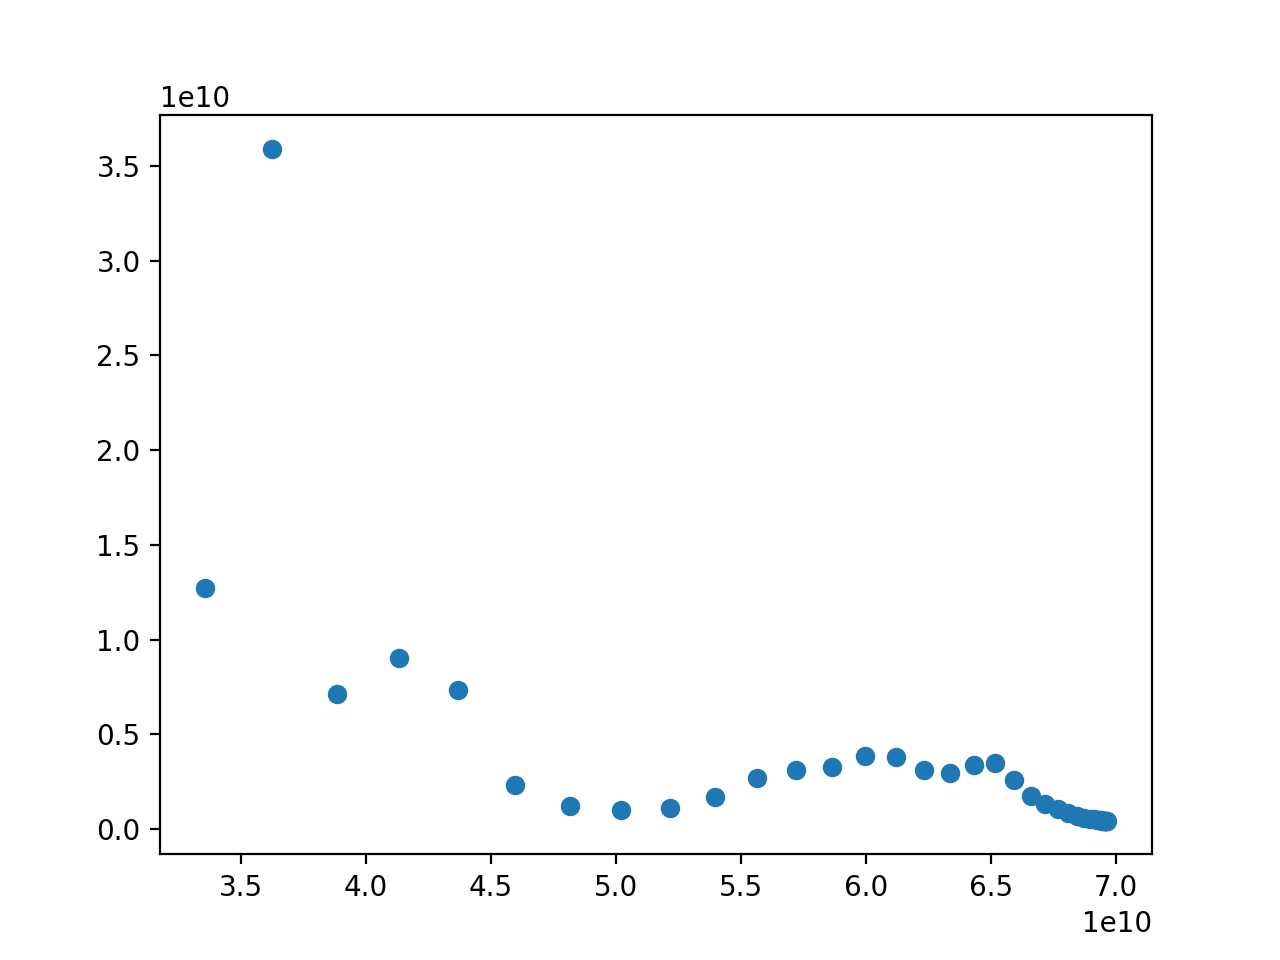

In [25]:
plt.figure()
plt.scatter(rr, Z_vsr)

In [26]:
# from choudhuri
dom2dz_choud = 1/5e8*1.4e-12
Z_est_choud = 2.6e-6**2/dom2dz_choud
Z_est_choud # significantly bigger than NSSL, which makes sense since he estimated from the bulk of CZ

2414285714.285714

<IPython.core.display.Javascript object>


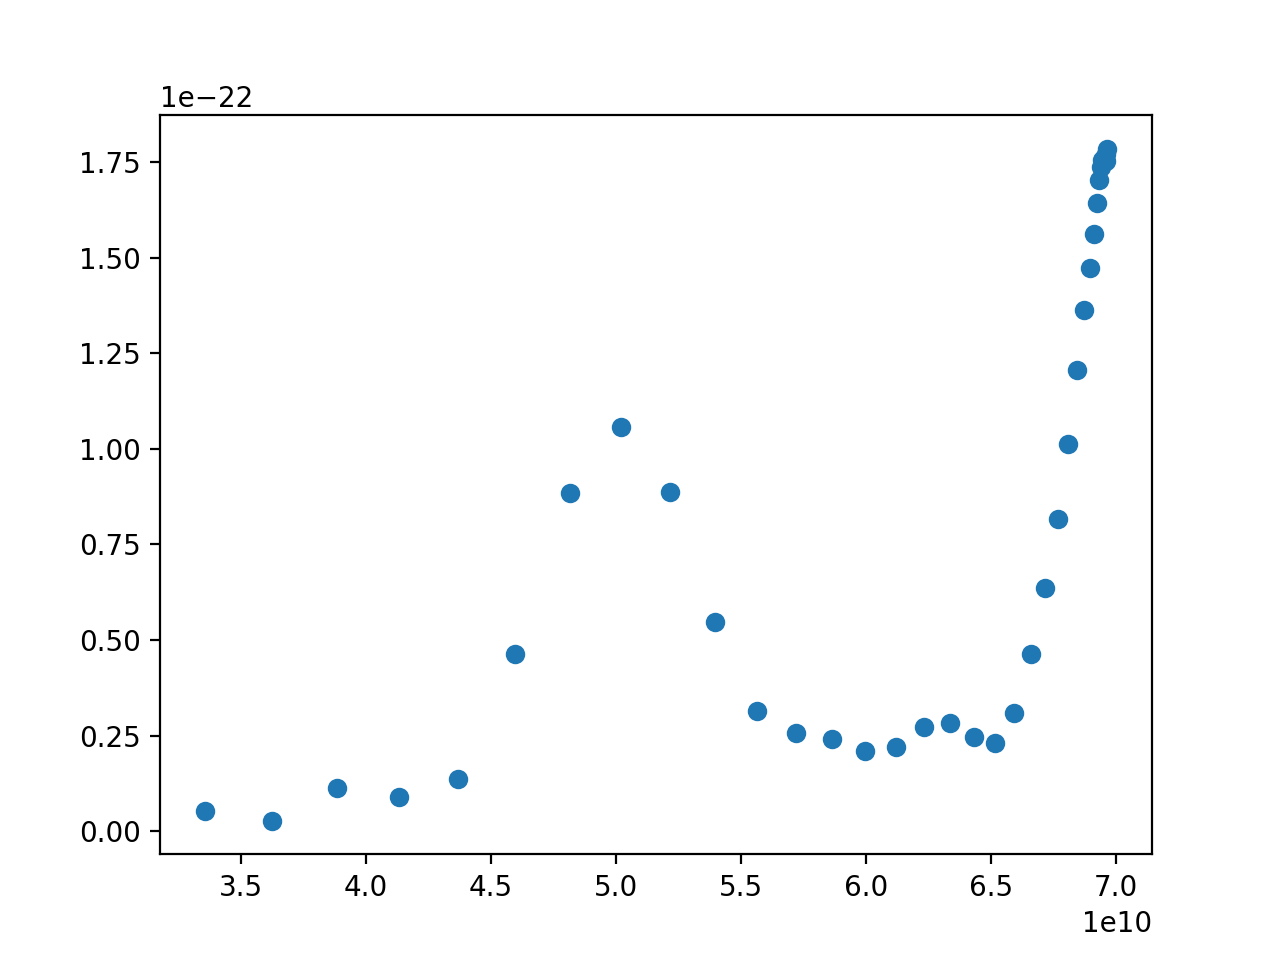

In [27]:
plt.figure()
plt.scatter(rr, np.mean(np.abs(dOm2dz), axis=0))

In [28]:
np.min(Om2)

3.924038822123125e-12

In [29]:
Z_vsr

array([4.24964733e+08, 4.28745915e+08, 4.33308540e+08, 4.33068057e+08,
       4.32459525e+08, 4.33655581e+08, 4.36083189e+08, 4.41879815e+08,
       4.53494085e+08, 4.73910501e+08, 5.03966224e+08, 5.40862210e+08,
       5.89143681e+08, 6.73205588e+08, 8.19453179e+08, 1.03410785e+09,
       1.31342054e+09, 1.75407166e+09, 2.57439106e+09, 3.46039940e+09,
       3.35318159e+09, 2.96591377e+09, 3.12018957e+09, 3.79576253e+09,
       3.84871704e+09, 3.26108413e+09, 3.10986916e+09, 2.69845527e+09,
       1.66449934e+09, 1.09274029e+09, 9.85990641e+08, 1.21200367e+09,
       2.29105299e+09, 7.32434729e+09, 9.02612703e+09, 7.11832929e+09,
       3.59160550e+10, 1.26988274e+10])

<IPython.core.display.Javascript object>


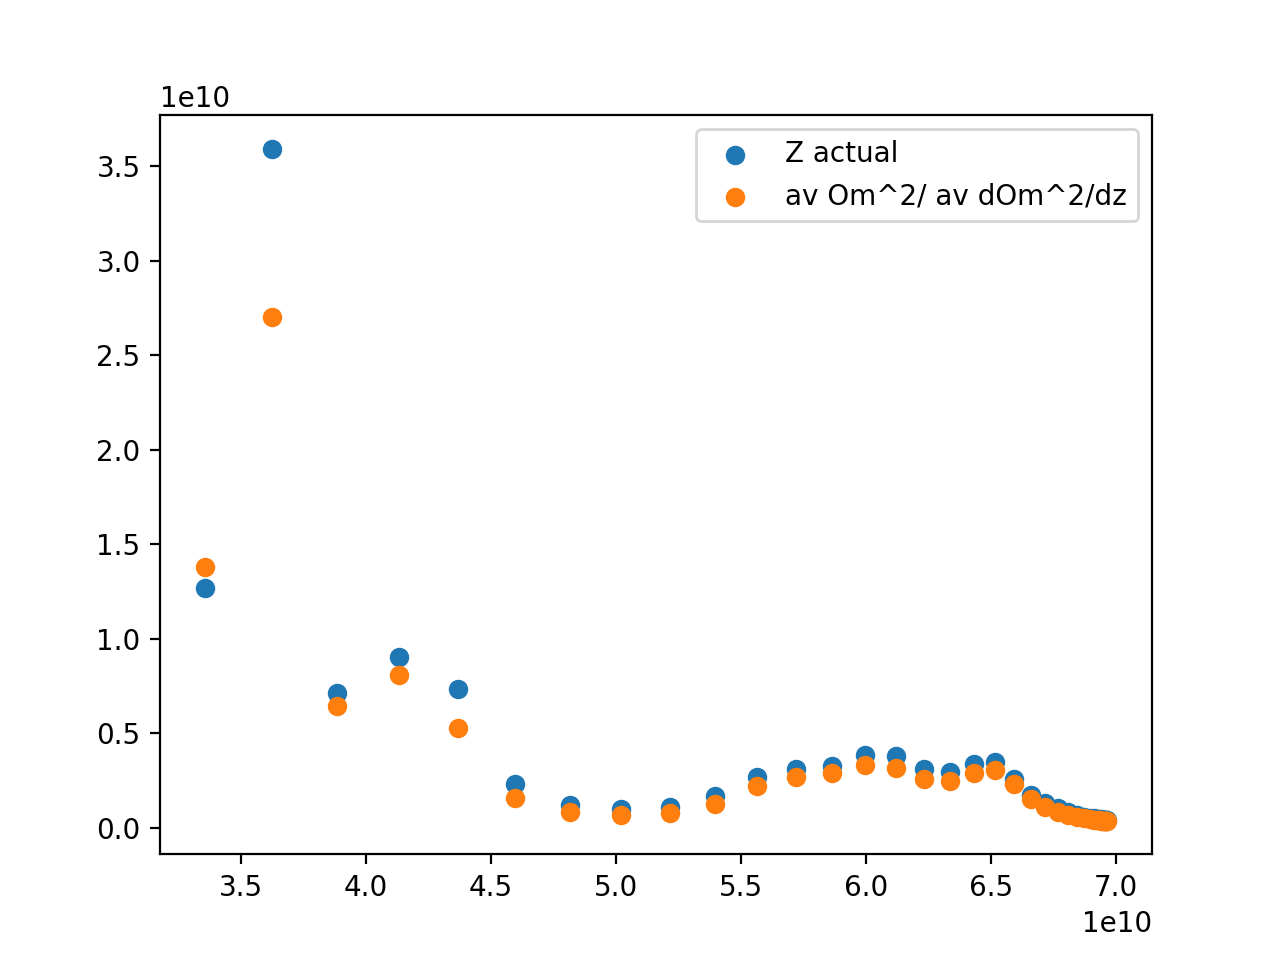

In [30]:
plt.figure()
plt.scatter(rr, Z_vsr, label = 'Z actual')
plt.scatter(rr, np.mean(Om2, axis=0)/np.mean(np.abs(dOm2dz), axis=0)/100, label = 'av Om^2/ av dOm^2/dz')
plt.legend()

<IPython.core.display.Javascript object>


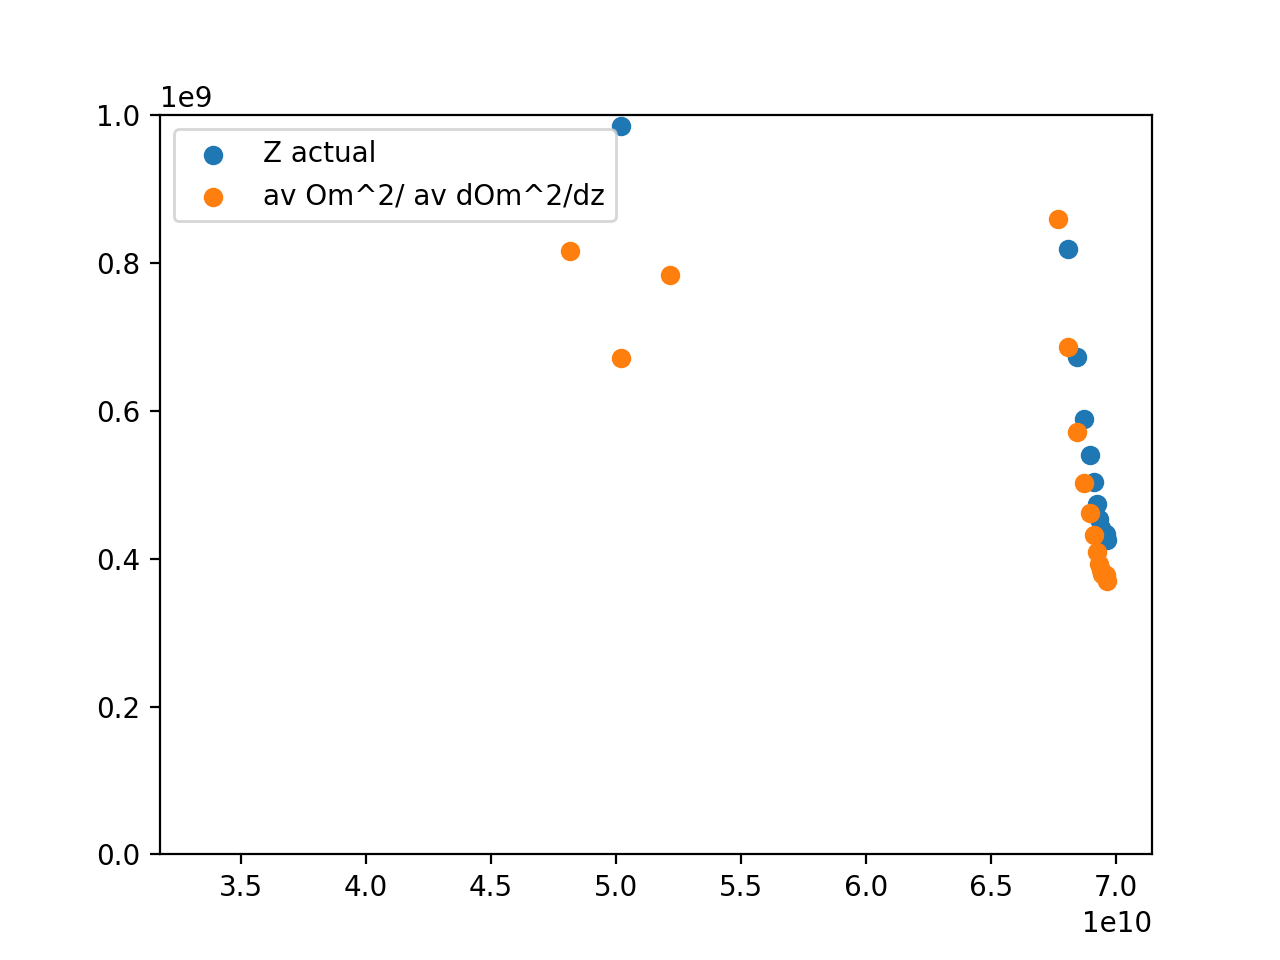

In [31]:
# zoom on relevant area
plt.figure()
plt.scatter(rr, Z_vsr, label = 'Z actual')
plt.scatter(rr, np.mean(Om2, axis=0)/np.mean(np.abs(dOm2dz), axis=0)/100, label = 'av Om^2/ av dOm^2/dz')
plt.ylim(0, 0.1e10)
plt.legend()

In [32]:
# hmm.... I think I was picking up some weird stuff by dividing things point by point
# 07/14/2023: Now I average Om^2 and dOm^2/dz separately before dividing them
# 07/23/2023: hmmm...I also was screwing up the spherical average.

In [47]:
# now (finally) store the data in a publicly accessible Zenodo repo
di_zen = dict(({}))

# basic data
di_zen['nr'] = nr
di_zen['nt'] = nt
di_zen['rr'] = rr
di_zen['rsun'] = rsun
di_zen['tt'] = tt
di_zen['tt_lat'] = tt_lat

# shear layer locations
rvals_full = np.hstack((rvals, np.array([rsun])))
irvals_full = inds_from_vals(rr, rvals_full)
di_zen['rvals'] = rvals_full
di_zen['irvals'] = irvals_full

# rotation rate properties
di_zen['Om'] = Om
di_zen['dOmdr'] = dOmdr
di_zen['dOmdt'] = dOmdt
di_zen['dOmdz'] = dOmdz
di_zen['dOmdl'] = dOmdl
di_zen['Om2'] = Om2
di_zen['dOm2dz'] = dOm2dz
di_zen['Om2_vsr'] = Om2_vsr
di_zen['dOm2dz_vsr'] = dOm2_vsr
di_zen['Z'] = Om2/dOm2dz
di_zen['Z_vsr'] = Z_vsr*100 # make sure everything is in same units

# model S data
di_zen['grav'] = grav
di_zen['c_p'] = c_p
di_zen['tmp'] = tmp
di_zen['rho'] = rho
di_zen['prs'] = prs
di_zen['beta'] = delta
di_zen['dtdp'] = dtdp
di_zen['dsdp'] = dsdp

# thermal anomalies, mer plane
di_zen['t_dev_nd_cent'] = t_dev_nd_cent
di_zen['t_dev_nd_quad'] = t_dev_nd_quad
di_zen['t_dev_nd_tw'] = t_dev_nd_tw

di_zen['s_dev_nd_cent'] = s_dev_nd_cent
di_zen['s_dev_nd_quad'] = s_dev_nd_quad
di_zen['s_dev_nd_tw'] = s_dev_nd_tw

di_zen['t_dev_cent'] = t_dev_cent
di_zen['t_dev_quad'] = t_dev_quad
di_zen['t_dev_tw'] = t_dev_tw

di_zen['s_dev_cent'] = s_dev_cent
di_zen['s_dev_quad'] = s_dev_quad
di_zen['s_dev_tw'] = s_dev_tw

# tmp contrasts
di_zen['dt_cent'] = dt_cent
di_zen['dt_quant'] = dt_quad
di_zen['dt_tw'] = dt_tw

# Okay I think that's it ... save it
f = open('zenodo_repo/tmp_anomalies_and_more.pkl', 'wb')
pickle.dump(di_zen, f, protocol=4)
f.close()

In [34]:
f2 = open('zenodo_repo/tmp_anomalies_and_more.pkl', 'rb') 
di_test = pickle.load(f2)
f2.close()
di_test['Z_vsr']

array([4.24964733e+10, 4.28745915e+10, 4.33308540e+10, 4.33068057e+10,
       4.32459525e+10, 4.33655581e+10, 4.36083189e+10, 4.41879815e+10,
       4.53494085e+10, 4.73910501e+10, 5.03966224e+10, 5.40862210e+10,
       5.89143681e+10, 6.73205588e+10, 8.19453179e+10, 1.03410785e+11,
       1.31342054e+11, 1.75407166e+11, 2.57439106e+11, 3.46039940e+11,
       3.35318159e+11, 2.96591377e+11, 3.12018957e+11, 3.79576253e+11,
       3.84871704e+11, 3.26108413e+11, 3.10986916e+11, 2.69845527e+11,
       1.66449934e+11, 1.09274029e+11, 9.85990641e+10, 1.21200367e+11,
       2.29105299e+11, 7.32434729e+11, 9.02612703e+11, 7.11832929e+11,
       3.59160550e+12, 1.26988274e+12])

In [35]:
grav

array([ 27348.7421956 ,  27362.41198665,  27377.18687659,  27395.20652881,
        27419.55306036,  27451.13115921,  27490.41883857,  27538.7908998 ,
        27598.70095512,  27674.20984388,  27771.65600465,  27900.49569606,
        28075.67256353,  28308.84226221,  28599.7682522 ,  28955.59151546,
        29387.95127077,  29904.89026009,  30513.49956712,  31222.47414861,
        32042.4638634 ,  32986.18565205,  34069.39549252,  35310.87141463,
        36734.17924009,  38368.27498234,  40249.36251958,  42423.55414565,
        44950.56406563,  47908.02170746,  51399.51884726,  55552.36472909,
        60458.5272382 ,  66254.13383698,  73131.9474616 ,  81342.22606367,
        91207.88733871, 103133.46891752])

In [36]:
rsun

69599062580.0

In [37]:
rr/rsun

array([1.00071 , 1.00046 , 1.00019 , 0.999861, 0.999417, 0.998842,
       0.998128, 0.997251, 0.996168, 0.994808, 0.993061, 0.990765,
       0.987668, 0.983589, 0.978567, 0.972523, 0.965319, 0.956899,
       0.947243, 0.936327, 0.924122, 0.910598, 0.895717, 0.879442,
       0.861725, 0.842515, 0.821754, 0.799374, 0.775292, 0.749417,
       0.721641, 0.691917, 0.660583, 0.627809, 0.593637, 0.55806 ,
       0.521026, 0.48245 ])

In [38]:
rvals

array([4.83713485e+10, 5.18513016e+10, 6.61191095e+10])

In [39]:
rvals/rsun

array([0.695, 0.745, 0.95 ])

In [40]:
irvals

array([31, 29, 18])

In [41]:
nr

38

In [42]:
rvals_full

array([4.83713485e+10, 5.18513016e+10, 6.61191095e+10, 6.95990626e+10])

In [43]:
irvals_full

array([31, 29, 18,  3])

In [44]:
np.mean(di_zen['Z_vsr'])/100/1e6

3240.466769717698

In [45]:
nt,nr

(41, 38)